In [2]:
import numpy as np   #manejo de vectores
import math as mt    #calculos matematicos y constantes
import sympy as sp   #calculo simbolico
import matplotlib. pyplot as plt  #graficos
from scipy.special import factorial
#from funciones.potencial import U, FU

#import statistics as st    #calculos estadisticos

## Potencial ratchet

In [6]:
#parametros del potencial V
C, V_0, x_0 = -1.1, 1/(2*mt.pi), -0.19

#estableciendo el potencial V
X =sp.symbols('X')
expr1 = V_0*(-1.1+sp.sin(2*sp.pi*(X-x_0)) +1/4 *sp.sin(4*sp.pi*(X-x_0))) #potencial V
expr2=sp.diff(expr1,X)   

#haciendo que V tome como argumentos vectores
V =sp.lambdify(X, expr1)
V_vector =np.vectorize(V)
Vdiff = sp.lambdify(X,expr2)
Vdiff_vector =np.vectorize(Vdiff)

#estableciendo el potencial efectivo U=V-F*x
def U(x,a,F,fact):  # a=0: V=0, a=1: V   ,fact:cambiar el periodo
    return a*V_vector(x*fact)-F*x
U_vector = np.vectorize(U)
#fuerza correspondiente de U
def FU(x,a,F,fact):   
    if a==0:
        return F
    return -a*Vdiff_vector(x*fact)+F
FU_vector = np.vectorize(FU,excluded=['a','F'])

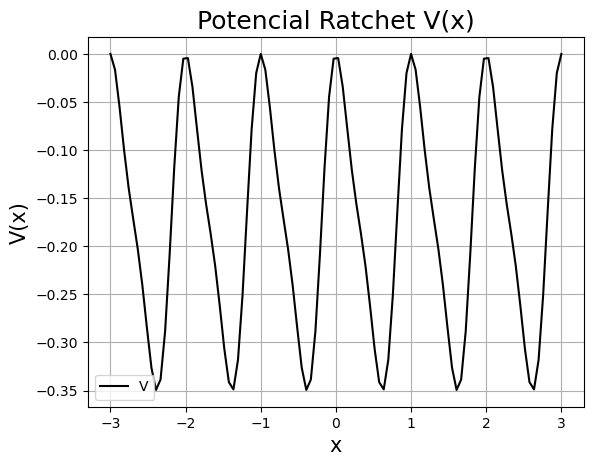

In [7]:
x=np.linspace(-3,3,100)
plt.plot(x,U_vector(x,1,0,1),label='V',color='black') #potencial V
plt.ylabel("V(x)",fontsize = 15)
plt.xlabel("x",fontsize = 15)
plt.grid()
plt.title('Potencial Ratchet V(x)',size=18)
plt.legend()
#save_fig('potencial_V', tight_layout=True, fig_extension="png", resolution=300)

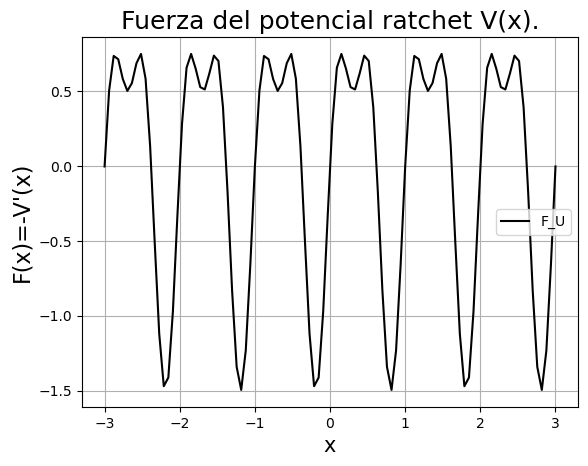

In [6]:
plt.plot(x,FU_vector(x,1,0,1),label='F_U',color='black') #fuerza F
plt.ylabel("F(x)=-V'(x)",fontsize = 16)
plt.xlabel("x",fontsize = 15)
plt.grid()
plt.title('Fuerza del potencial ratchet V(x).',size=18)
plt.legend()

#save_fig('fuerza_ratchet', tight_layout=True, fig_extension="png", resolution=300)

### Nuevo potencial ratchet

In [77]:
class v_ratchet:
    def __init__(self, x, VO, C, xo, L):
        self.VO = VO
        self.C = C
        self.xo = xo
        self.L = L
        self.x = x

    def value(self):
        term1 = np.sin(2*np.pi*(self.x-self.xo))
        term2 = 1/4*np.sin(4*np.pi*(self.x-self.xo))
        return -self.VO*(self.C + term1 + term2)

In [78]:
potencial = v_ratchet(x, VO=1/(2*np.pi), C=-1.1, xo=-0.19, L=1)

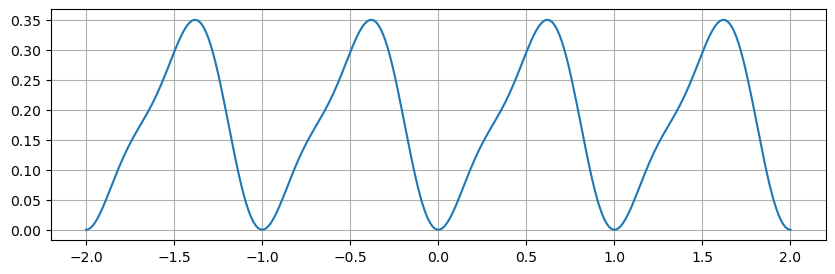

In [79]:
x = np.linspace(-2,2,300)
potencial.x = x

plt.figure(figsize=(10,3))
plt.plot(x, potencial.value())
plt.grid()

### Temporal modulation

In [192]:
class duty_cycle:
    def __init__(self, t, alpha, delta, f):
        self.alpha = alpha
        self.delta = delta
        self.t = t
        self.f = f
    
    def value(self):

        if self.t > 1/self.f:
            self.t = divmod(self.t,1/self.f)[1]
        if (0<self.t) and (self.t<self.delta/self.f):
            return 1
        else:
            return self.alpha

In [193]:
modulation = duty_cycle(t=0,alpha=-0.5, delta=0.25, f=1/5)

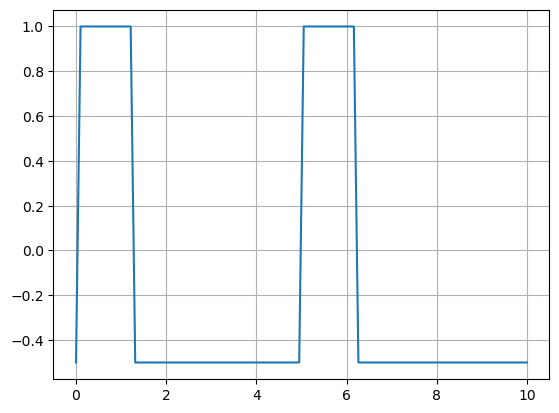

In [198]:
times = []
for i in np.linspace(0,10,100):
    modulation.t = i
    times.append(modulation.value())
plt.plot(np.linspace(0,10,100), times )
plt.grid()

### Force

In [72]:
class F_ratchet:
    def __init__(self, x, VO, xo, L):
        self.VO = VO
        self.xo = xo
        self.L = L
        self.x = x

    def value(self):
        term1 = 2*np.pi*np.cos(2*np.pi*(self.x-self.xo))
        term2 = np.pi*np.cos(4*np.pi*(self.x-self.xo))
        return -self.VO*(term1 + term2)

In [75]:
force = F_ratchet(x=0, VO=1/(2*np.pi), xo=-0.19, L=1)

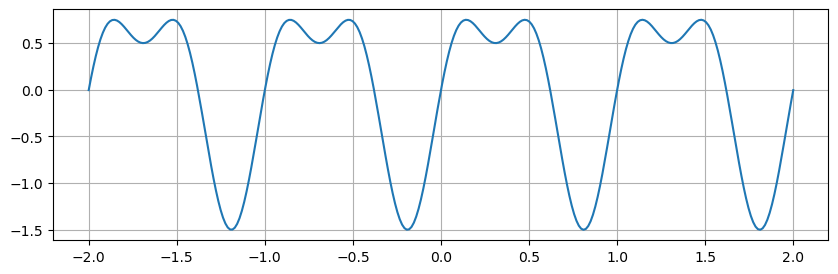

In [76]:
x = np.linspace(-2,2,300)
force.x = x

plt.figure(figsize=(10,3))
plt.plot(x, force.value())
plt.grid()

### Pulses

## Parametros de la simulacion

In [81]:
np.zeros(3)

array([0., 0., 0.])

In [187]:
def simulation(f,D=0.1):
    x_mean=[]
    x_disp=[]
    v_mean=[]

    N = 100
    X = np.zeros(N)
    force.x = X
    modulation.t = 0
    modulation.f = f

    dt = 0.001
    time_end = 10
    point_num = int(time_end/dt)
    times = np.linspace(0,time_end,point_num)

    #D=0.1
    for i in times:
        Xnew = X + dt*force.value()*modulation.value() + np.sqrt(2*D*dt)*np.random.normal(0,1,N)
        #X = X +  np.sqrt(2*D*dt)*np.random.normal(0,1,N)
        v_mean.append(np.mean((Xnew-X)/dt))
        X = Xnew
        #x_mean.append(np.mean(X))
        #x_disp.append(np.mean(X*X))
        force.x = X
        modulation.t = i
    
    return np.mean(v_mean)


In [189]:
v_neto = []
for f in np.linspace(50,100,100):
    v_neto.append(simulation(f=f,D=1.2*10**(-5)))

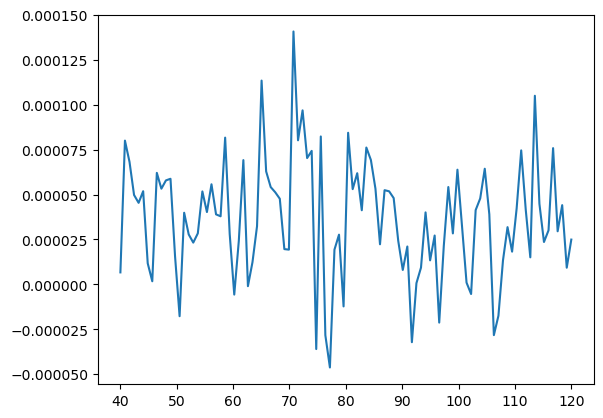

In [190]:
plt.plot(np.linspace(40,120,100), v_neto)

In [174]:
np.mean(v_mean)

0.011142151865637837

In [14]:
'''
PARMETROS:
a: considerar potencial si=1,no=0
F: modulo de la fuerza constante
D: coeficiente de difusion
dt: tiempo de paso
t: tiempo
on_off: semiperiodo del tiempo y apagado
parpadeo: si=True ,no=False
dN: cada cuantos pasos se almacenan los datos
''' 
def simulacion(a,F,num_particulas,D,dt,t,on_off,parpadeo,dN,fact):
    N=int(t/dt)   #N: numero de pasos 
    dN_2=int(on_off/dt)  #numero de pasos que se dan en el tiempo de  encendido o apagado
    X=np.zeros(num_particulas)  #vector que almacena las posiciones de N particulas
    X_old=np.zeros(num_particulas)  #posicion inicial de las particulas = 0
    
    #listas donde se almacenara los promedio de las mediciones
    posicion=[]
    POSICIONES=[]
    posicion_2=[]
    tiempo=[]
    velocidad=[]
    
    #condicion inicial de las mediciones
    posicion.append(0)
    posicion_2.append(0)
    tiempo.append(0)
    POSICIONES.append(np.zeros(num_particulas))
    velocidad.append(0)
    
    tau_list=[] #comprobando el encendido 1 y apagado 0
    tau_list.append(a) 
    
    for i in range(1,N):
        
        #encendido y apagado
        if parpadeo == True: #aqui es donde se apaga(a=0) y prende(a=1)
            if i%dN_2==0:
                if a==0:
                    a=1
                else: a=0
        
            
        t=t+dt*i #contabilizando el tiempo
        
        #realizacion del siguiente paso
        X = X + dt*FU_vector(X,a,F,fact)+ np.sqrt(2*D*dt)*np.random.normal(0,1,num_particulas)
        
        #despues de cada dN pasos se almacenan los datos
        if (i%dN) == 0:
            #salidas
            #eliminar el comando de comentario '#' de acuerdo a que variable desea medir 
            tiempo.append(i*dt)
            posicion.append(np.mean(X)) 
            POSICIONES.append(X)      
            #posicion_2.append(np.mean(X*X))    
            velocidad.append(np.mean((X-X_old)/(dN*dt)))   
            X_old=X   
            #tau_list.append(a)
            
    return  tiempo,posicion, velocidad #colocar las variables a los cuales elimino el #''


In [15]:
tiempo,x, v=simulacion(a=0,F=0,
                       num_particulas=2,
                       D=0.1,
                       dt=0.00005,
                       t=10,
                       on_off=0.00005*1000,
                       parpadeo=False,
                       dN=1000,
                       fact=1)

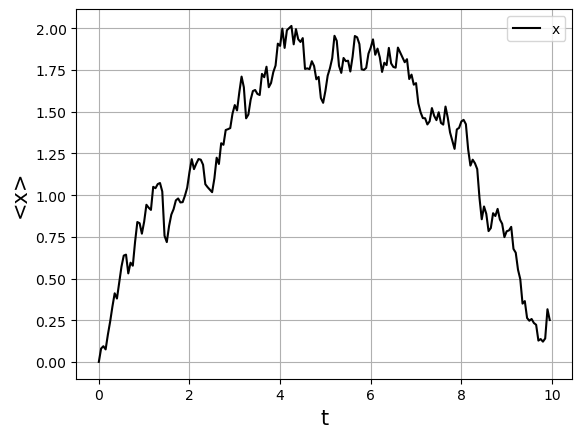

In [16]:
#graficando tiempo vs posicion
plt.plot(tiempo,x,label='x',color='black')
plt.xlabel("t",fontsize = 15)
plt.ylabel('<x>',fontsize = 15)
plt.grid()
#plt.ylim((-0.2,0.2))
#plt.title('<x> de 1000 partículas.',size=18)
plt.legend(fontsize=10)
#save_fig('wiener_posicion', tight_layout=True, fig_extension="png", resolution=300)

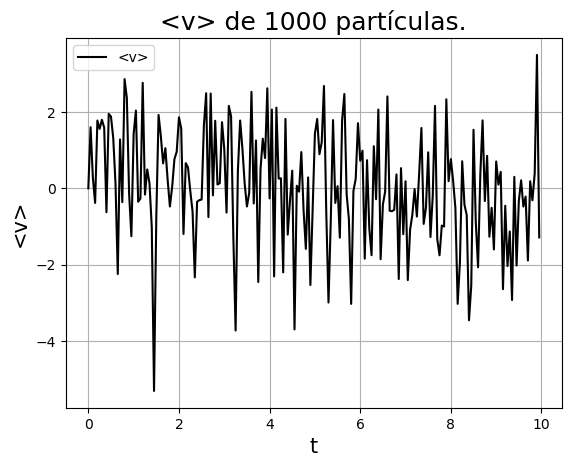

In [18]:
#graficando tiempo vs velocidad
plt.plot(tiempo,v,label='<v>',color='black') #potencial U con F_n=-1
plt.xlabel("t",fontsize = 15)
plt.ylabel('<v>',fontsize = 15)
plt.grid()

plt.title('<v> de 1000 partículas.',size=18)
plt.legend(fontsize=10) 
#save_fig('wiener_velocidad', tight_layout=True, fig_extension="png", resolution=300)